## LLM Pretraining

In [ ]:
#데이터 다운 

import kagglehub  #pip install kagglehub

# Download latest version
path = kagglehub.dataset_download("shubhammaindola/harry-potter-books")

print("Path to dataset files:", path)


### 데이터 텍스트 정리

In [2]:
import re

def clean_text(filename):
    with open(filename, 'r', encoding="utf-8") as file:
        book_text = file.read()
    
    cleaned_text = re.sub(r'\n+', ' ', book_text) # 줄바꿈을 빈칸으로 변경
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text) # 여러 빈칸을 하나의 빈칸으로
    
    print("cleaned_" + filename, len(cleaned_text), "characters") # 글자 수 출력
    
    
    with open( filename+"_cleaned", 'w', encoding='utf-8') as file:
        file.write(cleaned_text)
    
filenames_list = ["/home/moon/LLM_Study/data/harry-potter-books/versions/1/02 Harry Potter and the Chamber of Secrets.txt"]

for filename in filenames_list:
    clean_text(filename)
        

cleaned_/home/moon/LLM_Study/data/harry-potter-books/versions/1/02 Harry Potter and the Chamber of Secrets.txt 488771 characters


### 토큰 확인

In [3]:
import tiktoken #pip install tiktoken

tokenizer = tiktoken.get_encoding("gpt2")


text = "Harry Potter was a wizard."


tokens = tokenizer.encode(text)

print("글자수:", len(text), "토큰수",len(tokens))

print(tokens)

print(tokenizer.decode(tokens))

for t in tokens:
    print(f"{t}\t -> {tokenizer.decode([t])}")

글자수: 26 토큰수 6
[18308, 14179, 373, 257, 18731, 13]
Harry Potter was a wizard.
18308	 -> Harry
14179	 ->  Potter
373	 ->  was
257	 ->  a
18731	 ->  wizard
13	 -> .


In [4]:
for char in text:
    token_ids = tokenizer.encode(char) # 한 글자씩 인코딩
    decode =tokenizer.decode(token_ids)
    
    print (f"[ {char} ] -> {token_ids} ")

[ H ] -> [39] 
[ a ] -> [64] 
[ r ] -> [81] 
[ r ] -> [81] 
[ y ] -> [88] 
[   ] -> [220] 
[ P ] -> [47] 
[ o ] -> [78] 
[ t ] -> [83] 
[ t ] -> [83] 
[ e ] -> [68] 
[ r ] -> [81] 
[   ] -> [220] 
[ w ] -> [86] 
[ a ] -> [64] 
[ s ] -> [82] 
[   ] -> [220] 
[ a ] -> [64] 
[   ] -> [220] 
[ w ] -> [86] 
[ i ] -> [72] 
[ z ] -> [89] 
[ a ] -> [64] 
[ r ] -> [81] 
[ d ] -> [67] 
[ . ] -> [13] 


###  한국어 및 한자 토큰화

In [5]:
from transformers import AutoTokenizer # pip install transformers

tokenizer = AutoTokenizer.from_pretrained("LGAI-EXAONE/EXAONE-3.5-7.8B-Instruct")  # KoGPT2 사용
# tokenizer = AutoTokenizer.from_pretrained("skt/kogpt2-base-v2")  # KoGPT2 사용

print("Vocab size :", len(tokenizer))

text = "대사께서는 도(道)를 얻은 모양이구려."

tokens = tokenizer.encode(text)

print(len(text), len(tokens))
print(tokens)
print(tokenizer.decode(tokens))

/home/moon/miniconda3/envs/gpu_test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Vocab size : 102400
21 15
[31980, 1599, 712, 657, 769, 369, 26733, 370, 4605, 4573, 732, 5844, 634, 30556, 375]
대사께서는 도(道)를 얻은 모양이구려.


## 데이터 로더(DataLoader)

TEXT: Harry Potter was a Wizard. <br/>
input(i):  Harry Potter<br/>
target(i+1) was

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader

#pytorch Dataset상속받아서 만드는
class MyDataset(Dataset):
    def __init__(self, txt, max_length, stride):
        self.input_ids = [] 
        self.target_ids = []
        
        token_ids = tokenizer.encode(txt)
        
        print("# of tokens in txt:", len(token_ids))
        
        for i in range(0, len(token_ids) - max_length, stride ):
            input_chunk = token_ids[i:      i + max_length ]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
            
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [7]:
# with open("cleaned_한글문서.txt", 'r', encoding='utf-8-sig') as file: # 선택: -sig를 붙여서 BOM 제거
with open("/home/moon/LLM_Study/data/harry-potter-books/versions/1/02 Harry Potter and the Chamber of Secrets.txt_cleaned", 'r', encoding='utf-8-sig') as file: # 선택: -sig를 붙여서 BOM 제거
    txt = file.read()
    
    
dataset = MyDataset(txt, max_length=32, stride=4)

train_loader = DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True)

# of tokens in txt: 123176


In [38]:
dataiter = iter(train_loader)

x, y = next(dataiter)

print(tokenizer.decode(x[0].tolist()))

print("---")

print(tokenizer.decode(y[0].tolist()))

# 한 단어씩 밀려있는 형태!

, Miss Granger.” Lockhart stepped forward eagerly. “My office is nearest, Headmaster — just upstairs — please feel free —” “Thank you,
---
 Miss Granger.” Lockhart stepped forward eagerly. “My office is nearest, Headmaster — just upstairs — please feel free —” “Thank you, G


## 뉴럴네트워크 모델 정의

In [40]:
# 모델을 정의할 때 사용하는 상수들
VOCAB_SIZE =  tokenizer.vocab_size  # 50257 tiktoken # 단어가 몇 개 있나
# VOCAB_SIZE = len(toknizer) # AutoTokenizer

CONTEXT_LENGTH = 128  # Shortened context length (orig: 1024)
EMB_DIM = 768  # Embedding dimension
NUM_HEADS = 12  # Number of attention heads
NUM_LAYERS = 12  # Number of layers
DROP_RATE = 0.1  # Dropout rate
QKV_BIAS = False  # Query-key-value bias


In [41]:
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        
        assert d_out % NUM_HEADS == 0, "d_out must be divisible by n_heads"

        self.d_out = d_out
        self.head_dim = d_out // NUM_HEADS

        self.W_query = nn.Linear(d_in, d_out, bias=QKV_BIAS)
        self.W_key = nn.Linear(d_in, d_out, bias=QKV_BIAS)
        self.W_value = nn.Linear(d_in, d_out, bias=QKV_BIAS)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(DROP_RATE)
        self.register_buffer('mask', torch.triu(torch.ones(CONTEXT_LENGTH, CONTEXT_LENGTH), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)  # (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, NUM_HEADS, self.head_dim)
        values = values.view(b, num_tokens, NUM_HEADS, self.head_dim)
        queries = queries.view(b, num_tokens, NUM_HEADS, self.head_dim)

        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)

        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)

        return context_vec

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

class FeedForward(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(EMB_DIM, 4 * EMB_DIM),
            GELU(),
            nn.Linear(4 * EMB_DIM, EMB_DIM),
        )

    def forward(self, x):
        return self.layers(x)

class TransformerBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=EMB_DIM,
            d_out=EMB_DIM)
    
        self.ff = FeedForward()
        self.norm1 = LayerNorm(EMB_DIM)
        self.norm2 = LayerNorm(EMB_DIM)
        self.drop_shortcut = nn.Dropout(DROP_RATE)

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x


class GPTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.tok_emb = nn.Embedding(VOCAB_SIZE, EMB_DIM)
        self.pos_emb = nn.Embedding(CONTEXT_LENGTH, EMB_DIM)
        self.drop_emb = nn.Dropout(DROP_RATE)

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock() for _ in range(NUM_LAYERS)])

        self.final_norm = LayerNorm(EMB_DIM)
        self.out_head = nn.Linear(EMB_DIM, VOCAB_SIZE, bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [43]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(device)


torch.manual_seed(123)
model = GPTModel()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)


cuda


In [44]:
tokens_seen, global_step = 0, -1

losses = []

for epoch in range(10):
    model.train()  # Set model to training mode
    
    epoch_loss = 0
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad() # Reset loss gradients from previous batch iteration
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)

        logits = model(input_batch)
        loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
        epoch_loss += loss.item()
        loss.backward() # Calculate loss gradients
        optimizer.step() # Update model weights using loss gradients
        tokens_seen += input_batch.numel()
        global_step += 1

        if global_step % 1000 == 0:
            print(f"Tokens seen: {tokens_seen}")
        # Optional evaluation step

    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch: {epoch + 1}, Loss: {avg_loss}")
    torch.save(model.state_dict(), "model_" + str(epoch + 1).zfill(3) + ".pth")

# 주의: 여기서는 편의상 모든 데이터를 train에 사용하였습니다. 
#      ML에서는 일부 데이터를 validation에 사용하는 것이 일반적입니다.

Tokens seen: 4096
Epoch: 1, Loss: 4.7848054001728695
Epoch: 2, Loss: 2.513247337937355
Epoch: 3, Loss: 0.9165150910615921
Epoch: 4, Loss: 0.40819243565201757
Tokens seen: 4100096
Epoch: 5, Loss: 0.3051235786328713
Epoch: 6, Loss: 0.2688799823323886
Epoch: 7, Loss: 0.24879281626393399
Epoch: 8, Loss: 0.23681814974794785
Tokens seen: 8196096
Epoch: 9, Loss: 0.23129487211505573
Epoch: 10, Loss: 0.22539350235213837


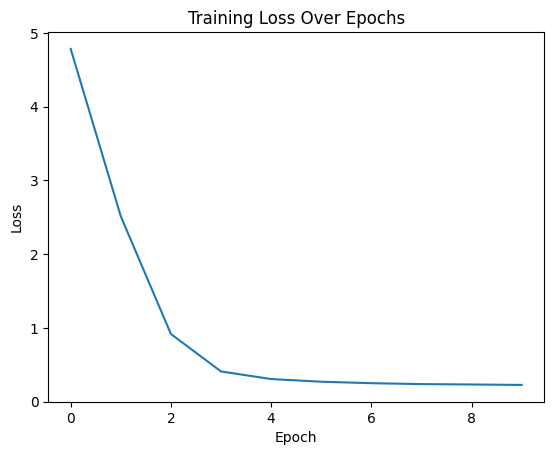

In [45]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()


In [47]:
# 파일로 저장했던 네트워크의 가중치들 읽어들이기
model.load_state_dict(torch.load("model_009.pth", map_location=device, weights_only=True))
model.eval() # dropout을 사용하지 않음

GPTModel(
  (tok_emb): Embedding(102400, 768)
  (pos_emb): Embedding(128, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_feature

In [48]:
idx = tokenizer.encode("Dobby is") # 토큰 id의 list
idx = torch.tensor(idx).unsqueeze(0).to(device)

with torch.no_grad():
    logits = model(idx)

logits = logits[:, -1, :]

# 가장 확률이 높은 단어 10개 출력
top_logits, top_indices = torch.topk(logits, 10) 
for p, i in zip(top_logits.squeeze(0).tolist(), top_indices.squeeze(0).tolist()):
    print(f"{p:.2f}\t {i}\t {tokenizer.decode([i])}")

# 가장 확률이 높은 단어 출력
idx_next = torch.argmax(logits, dim=-1, keepdim=True)
flat = idx_next.squeeze(0) # 배치 차원 제거 torch.Size([1])
out = tokenizer.decode(flat.tolist()) # 텐서를 리스트로 바꿔서 디코드


15.09	 1814	  used
12.70	 3431	  always
11.20	 2669	  still
9.76	 619	  a
9.70	 4072	  sent
9.11	 12640	  caught
8.87	 8817	  nearest
8.82	 2992	  free
8.68	 14861	  suddenly
8.59	 24253	  warned


: 